In [178]:
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
from deepagri.data_pred import get_X_pred
from deepagri.data_prod import get_df_all
from deepagri.data_rendement import get_data_rendement
import requests
from tqdm import tqdm

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import joblib

/Users/constantintalandier/.pyenv/versions/3.8.12/envs/deepagri/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
# Custom MAE that considers y_pred=0 if y_pred < 0, y_pred otherwise
def loss_mae_relu(y_true, y_pred):
    y_pred  = np.maximum(y_pred, 0)
    return np.mean(np.abs(y_true - y_pred))

mae_relu = make_scorer(loss_mae_relu, greater_is_better=True)

In [170]:
# Load yield data, surfaces estimations, 
df_rend = pd.read_csv('full_df_rendement.csv')
surfaces_2022 = pd.read_csv('surfaces2022.csv')
pred_2022 = get_X_pred(agg_type='M')

/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/.pyenv/ve

In [159]:
# Baseline for yield: 
mean_absolute_error(df_rend.loc[93*5:, 'rendement'], df_rend.loc[93*5:, 'rendement_n-1'])

10.281318238419363

In [288]:
df_rend

,Unnamed: 0,Agriculteur,rendement,rendement_n-1,RatioSep,RatioOct,Prix_matos,tmax_c 01,tmax_c 02,tmax_c 03,...,tmin_deg 05,tmin_deg 09_n-1,tmin_deg 10_n-1,tmin_deg 11_n-1,tmin_deg 12_n-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,2010-1,2820.041792,71.964054,69.712601,1.229426,1.255319,92.741667,7.0,5.0,7.0,...,3.0,6.0,-3.0,2.0,-9.0,0,1,0,0,0
1,2010-2,3563.698886,83.685590,89.977942,1.229426,1.255319,92.741667,4.0,6.0,7.0,...,4.0,8.0,0.0,3.0,-8.0,0,0,0,0,1
2,2010-3,4276.654443,65.000000,68.000000,1.229426,1.255319,92.741667,6.0,5.0,9.0,...,2.0,7.0,-4.0,0.0,-7.0,0,1,0,0,0
3,2010-4,1462.803043,33.000000,35.000000,1.229426,1.255319,92.741667,3.0,6.0,6.0,...,3.0,6.0,-4.0,-2.0,-12.0,1,0,0,0,0
4,2010-5,1406.337173,41.000000,41.000000,1.229426,1.255319,92.741667,3.0,5.0,4.0,...,-1.0,-1.0,-11.0,-9.0,-21.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2021-91,422.282609,81.000000,72.000000,1.104197,1.072703,89.891667,6.0,4.0,4.0,...,6.0,10.0,7.0,3.0,2.0,0,1,0,0,0
1112,2021-93,80.734902,83.000000,78.000000,1.104197,1.072703,89.891667,14.0,6.0,8.0,...,10.0,12.0,10.0,6.0,6.0,1,0,0,0,0
1113,2021-94,65.237675,81.000000,72.000000,1.104197,1.072703,89.891667,5.0,4.0,4.0,...,7.0,10.0,8.0,4.0,2.0,1,0,0,0,0
1114,2021-95,213.709486,83.000000,78.000000,1.104197,1.072703,89.891667,8.0,5.0,4.0,...,5.0,9.0,7.0,3.0,-1.0,0,1,0,0,0


Agriculteur
Agriculteur 10.180002732592614
rendement_n-1
rendement_n-1 9.530154745906374
RatioSep
RatioOct
Prix_matos
tmax_c 01
tmax_c 01 9.511473200220347
tmax_c 02
tmax_c 03
tmax_c 04
tmax_c 05
tmax_c 09_n-1
tmax_c 09_n-1 9.50906125398557
tmax_c 10_n-1
tmax_c 11_n-1
tmax_c 12_n-1
tmin_c 01
tmin_c 01 9.47357587073564
tmin_c 02
tmin_c 03
tmin_c 04
tmin_c 05
tmin_c 09_n-1
tmin_c 10_n-1
tmin_c 11_n-1
tmin_c 12_n-1
windspeed_max 01
windspeed_max 01 9.399539284060092
windspeed_max 02
windspeed_max 03
windspeed_max 04
windspeed_max 04 9.249552644390574
windspeed_max 05
windspeed_max 09_n-1
windspeed_max 09_n-1 9.204163086138134
windspeed_max 10_n-1
windspeed_max 10_n-1 9.124351477768588
windspeed_max 11_n-1
windspeed_max 12_n-1
rain_mm 01
rain_mm 02
rain_mm 03
rain_mm 04
rain_mm 05
rain_mm 09_n-1
rain_mm 10_n-1
rain_mm 10_n-1 9.114910371225347
rain_mm 11_n-1
rain_mm 11_n-1 9.111700993845558
rain_mm 12_n-1
humidity_pct 01
humidity_pct 02
humidity_pct 03
humidity_pct 04
humidity_pct 05
humidi

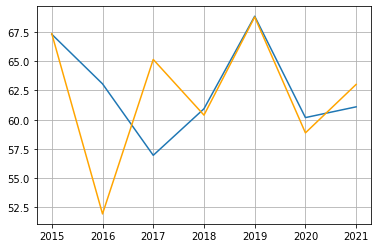

In [302]:


best_score=10.28
features = [
            'cluster_0',
            'cluster_1',
            'cluster_2',
            'cluster_3',
            'cluster_4',
        ]

for feat in df_rend.set_index('Unnamed: 0').drop(columns=['rendement']).columns:
    print(feat)
    score = []
    pred = []
    reel = []
    features.append(feat)
    for ligne in range(93 * 5, df_rend.shape[0], 93):
        model = Pipeline([('Scaling', StandardScaler()),
            ('Linear', LinearRegression())])



        X_train = df_rend.iloc[:ligne][features]
        y_train = df_rend.iloc[:ligne]['rendement']


        X_test = df_rend.iloc[ligne:ligne + 93][features]
        y_test = df_rend.iloc[ligne:ligne + 93]['rendement']


        model.fit(X_train, y_train)

        pred.append(model.predict(X_test))
        reel.append(y_test)
        score.append(loss_mae_relu(y_test, pred[-1]))
    score_mean=np.mean(score)
    if score_mean<best_score:
        best_score=score_mean
        print(feat,score_mean)
    else:
        features.remove(feat)
        

pred = np.array(pred)
reel = np.array(reel)
print(np.mean(score))
index_plot=list(range(2015,2022))
plt.plot(index_plot,pred.mean(axis=1))
plt.plot(index_plot,reel.mean(axis=1),c='orange')
plt.grid()

In [299]:
features

['Agriculteur',
 'tmax_c 01',
 'tmin_c 02',
 'tmin_c 04',
 'tmin_c 10_n-1',
 'windspeed_max 09_n-1',
 'windspeed_max 10_n-1',
 'rain_mm 10_n-1',
 'humidity_pct 10_n-1',
 'humidity_pct 11_n-1',
 'pressuremax_mb 04',
 'pressuremax_mb 09_n-1',
 'dewmax_c 02',
 'dewmax_c 11_n-1',
 'snow_mm 03',
 'snow_mm 05',
 'snow_mm 11_n-1',
 'tmax_deg 01',
 'tmax_deg 09_n-1',
 'tmax_deg 10_n-1',
 'tmin_deg 01',
 'tmin_deg 04',
 'tmin_deg 09_n-1',
 'tmin_deg 11_n-1',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4']

10.171916418089953


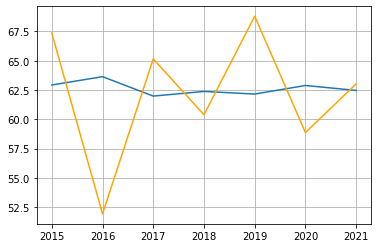

In [286]:
score = []
pred = []
reel = []

for ligne in range(93 * 5, df_rend.shape[0], 93):
    model = Pipeline([('Scaling', StandardScaler()),
        ('Linear', LinearRegression())])


    features = [
        'cluster_0',
        'cluster_1',
        'cluster_2',
        'cluster_3',
        'cluster_4'
    ]

    X_train = df_rend.iloc[:ligne][features]
    y_train = df_rend.iloc[:ligne]['rendement']


    X_test = df_rend.iloc[ligne:ligne + 93][features]
    y_test = df_rend.iloc[ligne:ligne + 93]['rendement']

 
    model.fit(X_train, y_train)
    
    pred.append(model.predict(X_test))
    reel.append(y_test)
    score.append(loss_mae_relu(y_test, pred[-1]))

pred = np.array(pred)
reel = np.array(reel)
print(np.mean(score))
index_plot=list(range(2015,2022))
plt.plot(index_plot,pred.mean(axis=1))
plt.plot(index_plot,reel.mean(axis=1),c='orange')
plt.grid()

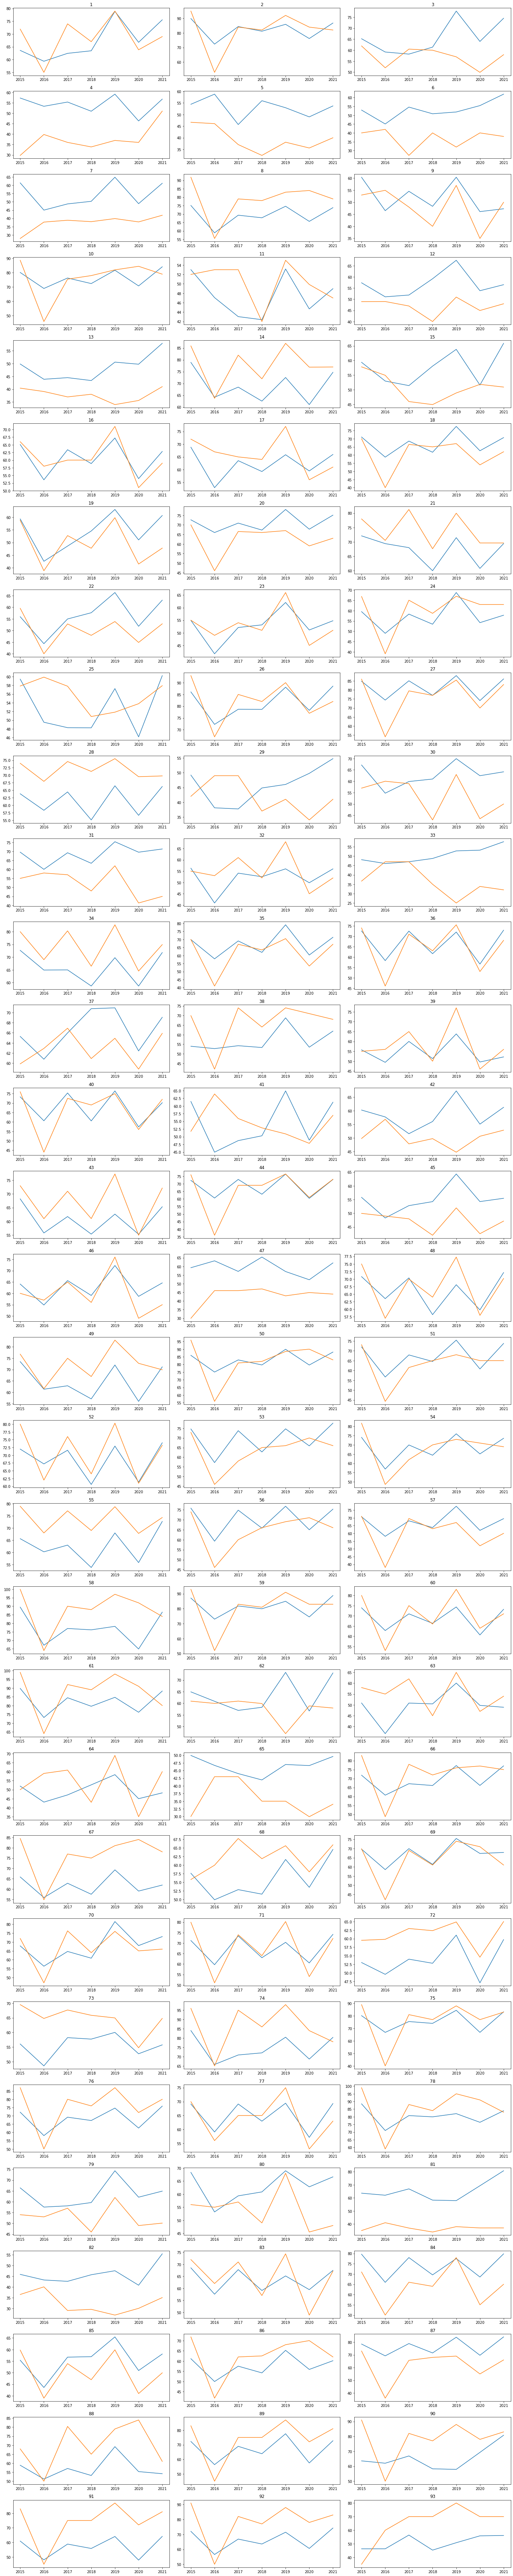

In [267]:
fig,axs=plt.subplots(31,3,figsize=(20,100))
count=0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        points_pred=[]
        points_reel=[]
        for k in range(len(reel)):
            points_pred.append(pred[k][count])
            points_reel.append(reel[k][count])
        axs[i][j].plot(index_plot,points_pred)
        axs[i][j].plot(index_plot,points_reel)
        axs[i][j].set_title(count+1)
        count+=1
plt.tight_layout()

In [8]:
df_rend

,Unnamed: 0,Agriculteur,rendement,rendement_n-1,RatioSep,RatioOct,Prix_matos,tmax_c 01,tmax_c 02,tmax_c 03,...,tmin_deg 05,tmin_deg 09_n-1,tmin_deg 10_n-1,tmin_deg 11_n-1,tmin_deg 12_n-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,2010-1,2820.041792,71.964054,69.712601,1.229426,1.255319,92.741667,7.0,5.0,7.0,...,3.0,6.0,-3.0,2.0,-9.0,0,1,0,0,0
1,2010-2,3563.698886,83.685590,89.977942,1.229426,1.255319,92.741667,4.0,6.0,7.0,...,4.0,8.0,0.0,3.0,-8.0,0,0,0,0,1
2,2010-3,4276.654443,65.000000,68.000000,1.229426,1.255319,92.741667,6.0,5.0,9.0,...,2.0,7.0,-4.0,0.0,-7.0,0,1,0,0,0
3,2010-4,1462.803043,33.000000,35.000000,1.229426,1.255319,92.741667,3.0,6.0,6.0,...,3.0,6.0,-4.0,-2.0,-12.0,1,0,0,0,0
4,2010-5,1406.337173,41.000000,41.000000,1.229426,1.255319,92.741667,3.0,5.0,4.0,...,-1.0,-1.0,-11.0,-9.0,-21.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2021-91,422.282609,81.000000,72.000000,1.104197,1.072703,89.891667,6.0,4.0,4.0,...,6.0,10.0,7.0,3.0,2.0,0,1,0,0,0
1112,2021-93,80.734902,83.000000,78.000000,1.104197,1.072703,89.891667,14.0,6.0,8.0,...,10.0,12.0,10.0,6.0,6.0,1,0,0,0,0
1113,2021-94,65.237675,81.000000,72.000000,1.104197,1.072703,89.891667,5.0,4.0,4.0,...,7.0,10.0,8.0,4.0,2.0,1,0,0,0,0
1114,2021-95,213.709486,83.000000,78.000000,1.104197,1.072703,89.891667,8.0,5.0,4.0,...,5.0,9.0,7.0,3.0,-1.0,0,1,0,0,0


In [121]:
list(df_rend.columns)

['Unnamed: 0',
 'Agriculteur',
 'rendement',
 'rendement_n-1',
 'RatioSep',
 'RatioOct',
 'Prix_matos',
 'tmax_c 01',
 'tmax_c 02',
 'tmax_c 03',
 'tmax_c 04',
 'tmax_c 05',
 'tmax_c 09_n-1',
 'tmax_c 10_n-1',
 'tmax_c 11_n-1',
 'tmax_c 12_n-1',
 'tmin_c 01',
 'tmin_c 02',
 'tmin_c 03',
 'tmin_c 04',
 'tmin_c 05',
 'tmin_c 09_n-1',
 'tmin_c 10_n-1',
 'tmin_c 11_n-1',
 'tmin_c 12_n-1',
 'windspeed_max 01',
 'windspeed_max 02',
 'windspeed_max 03',
 'windspeed_max 04',
 'windspeed_max 05',
 'windspeed_max 09_n-1',
 'windspeed_max 10_n-1',
 'windspeed_max 11_n-1',
 'windspeed_max 12_n-1',
 'rain_mm 01',
 'rain_mm 02',
 'rain_mm 03',
 'rain_mm 04',
 'rain_mm 05',
 'rain_mm 09_n-1',
 'rain_mm 10_n-1',
 'rain_mm 11_n-1',
 'rain_mm 12_n-1',
 'humidity_pct 01',
 'humidity_pct 02',
 'humidity_pct 03',
 'humidity_pct 04',
 'humidity_pct 05',
 'humidity_pct 09_n-1',
 'humidity_pct 10_n-1',
 'humidity_pct 11_n-1',
 'humidity_pct 12_n-1',
 'pressuremax_mb 01',
 'pressuremax_mb 02',
 'pressuremax_mb

In [9]:
# Create sample for 2022, rendement 2021 becomes rendement_n-1 feature for 2022
sample_2022 = df_rend.iloc[-93:][features].copy()
sample_2022.rename(columns={'rendement': 'rendement_n-1'}, inplace=True)

In [10]:
sample_2022.iloc[0]

cluster_0                 0.000000
cluster_1                 1.000000
cluster_2                 0.000000
cluster_3                 0.000000
cluster_4                 0.000000
windspeed_max 09_n-1      7.766667
windspeed_max 11_n-1      7.733333
tmin_c 10_n-1            27.000000
tmax_c 01                 6.000000
dewmax_c 09_n-1          18.000000
uv_idx 01                 1.451613
uv_idx 03                 2.645161
tmin_deg 10_n-1           2.000000
tmax_c 04                 6.000000
dewmax_c 11_n-1          12.000000
snow_mm 03                1.400000
tmax_deg 05              23.000000
rain_mm 10_n-1          273.500000
rain_mm 11_n-1           17.500000
Name: 1023, dtype: float64

In [11]:
# Drop 75, 92 and 96 for Paris, Hauts de Seine, France
for i in [74, 91, 95]:
    surfaces_2022.drop(i, axis=0, inplace=True)

In [12]:
# Predict on 2022 sample
pred = model.predict(sample_2022)

In [13]:
pred

array([73.99937688, 85.20078636, 72.04246178, 54.15577661, 51.90091072,
       58.09696224, 58.78762402, 71.61799101, 49.33056948, 81.64908476,
       48.88990613, 55.77752112, 55.52723052, 73.46290059, 61.837408  ,
       63.13038893, 66.2161086 , 70.40052366, 58.6996914 , 72.75928563,
       68.34823938, 61.7277216 , 53.54947609, 55.83224008, 57.38491753,
       86.63808036, 86.19256144, 63.81759222, 51.76049972, 65.78303068,
       67.91794876, 53.83827083, 55.93380818, 69.67310877, 70.86122505,
       71.29650325, 70.19374131, 60.18959181, 51.98861011, 69.87747544,
       58.78762402, 58.80455731, 63.38721855, 72.27351684, 55.81697048,
       66.06441847, 58.92672156, 68.78415373, 68.27351914, 86.61019949,
       69.98836612, 71.78233821, 75.31907801, 72.23806303, 68.311488  ,
       74.29095869, 67.95960763, 83.55975732, 87.22767167, 71.112818  ,
       85.9198241 , 70.74979817, 48.43178419, 49.11862192, 46.29374452,
       75.96546291, 58.55114684, 61.86615247, 66.15337713, 69.96

In [16]:
# Multiply predicted yield with estimated surfaces to get national prediction for production
np.sum(pred * surfaces_2022['2022']) / 10**7

34.81686766213322

In [268]:
model = Pipeline([('Scaling', StandardScaler()),
        ('Linear', LinearRegression())])

X = df_rend[features]
y = df_rend['rendement']
model.fit(X,y)

Pipeline(steps=[('Scaling', StandardScaler()), ('Linear', LinearRegression())])

In [224]:
joblib.dump(model,'Model_DeepAgri.joblib')

['Model_DeepAgri.joblib']

In [79]:
def pred(Serie):
    url='https://deepagridocker-tdgkcolwlq-ew.a.run.app/predict'
    params={
        'cluster_0':Serie['cluster_0'],
        'cluster_1':Serie['cluster_1'],
        'cluster_2':Serie['cluster_2'],
        'cluster_3':Serie['cluster_3'],
        'cluster_4':Serie['cluster_4'],
        'windspeed_max_09_n_1':Serie['windspeed_max 09_n-1'],
        'windspeed_max_11_n_1':Serie['windspeed_max 11_n-1'],
        'tmin_c_10_n_1':Serie['tmin_c 10_n-1'],
        'tmax_c_01':Serie['tmax_c 01'],
        'dewmax_c_09_n_1':Serie['dewmax_c 09_n-1'],
        'uv_idx_01':Serie['uv_idx 01'],
        'uv_idx_03':Serie['uv_idx 03'],
        'tmin_deg_10_n_1':Serie['tmin_deg 10_n-1'],
        'tmax_c_04':Serie['tmax_c 04'],
        'dewmax_c_11_n_1':Serie['dewmax_c 11_n-1'],
        'snow_mm_03':Serie['snow_mm 03'],
        'tmax_deg_05':Serie['tmax_deg 05'],
        'rain_mm_10_n_1':Serie['rain_mm 10_n-1'],
        'rain_mm_11_n_1':Serie['rain_mm 11_n-1']
    }
    resp=requests.get(url,params).json()
    return(resp['Rendement'])
    

In [87]:
rep=pd.DataFrame(sample_2022.apply(pred,axis=1))

rep

,0
1023,72.710509
1024,84.077682
1025,70.600377
1026,52.807354
1027,50.333667
...,...
1111,70.345137
1112,64.399084
1113,59.933445
1114,72.334221


In [132]:
sample_2022

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,windspeed_max 09_n-1,windspeed_max 11_n-1,tmin_c 10_n-1,tmax_c 01,dewmax_c 09_n-1,uv_idx 01,uv_idx 03,tmin_deg 10_n-1,tmax_c 04,dewmax_c 11_n-1,snow_mm 03,tmax_deg 05,rain_mm 10_n-1,rain_mm 11_n-1
1023,0,1,0,0,0,7.766667,7.733333,27.0,6.0,18.0,1.451613,2.645161,2.0,6.0,12.0,1.4,23.0,273.5,17.5
1024,0,0,0,0,1,16.233333,18.100000,24.0,7.0,17.0,1.548387,2.677419,5.0,4.0,16.0,0.0,21.0,165.1,40.1
1025,0,1,0,0,0,8.433333,7.466667,27.0,7.0,16.0,1.516129,2.451613,2.0,5.0,13.0,0.3,23.0,133.5,13.1
1026,1,0,0,0,0,10.166667,5.733333,26.0,6.0,16.0,1.580645,2.645161,-1.0,6.0,11.0,15.1,24.0,129.9,19.8
1027,1,0,0,0,0,7.900000,5.666667,24.0,9.0,14.0,1.580645,2.419355,-5.0,5.0,11.0,3.2,21.0,206.4,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,0,1,0,0,0,13.100000,14.433333,25.0,6.0,17.0,1.741935,3.000000,7.0,4.0,15.0,0.0,23.0,105.6,11.8
1112,1,0,0,0,0,19.400000,19.400000,52.0,14.0,20.0,2.838710,3.935484,10.0,14.0,15.0,0.0,23.0,129.8,40.6
1113,1,0,0,0,0,12.433333,13.566667,24.0,5.0,17.0,1.774194,3.096774,8.0,4.0,15.0,0.0,23.0,122.3,21.4
1114,0,1,0,0,0,13.766667,14.966667,27.0,8.0,17.0,1.645161,2.903226,7.0,4.0,15.0,0.0,22.0,130.2,22.1


In [110]:
df_cluster=df_rend.set_index('Unnamed: 0').copy()
df_cluster=df_cluster[['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4']]
df_cluster=df_cluster.loc['2021-1':]
df_cluster['dep']=df_cluster.index.str[5:]
df_cluster['year']=df_cluster.index.str[:4].astype(int)+1
df_cluster['Ind']=df_cluster['year'].astype(str)+'-'+df_cluster['dep']
df_cluster=df_cluster.drop(columns=['dep','year'])
df_cluster=df_cluster.set_index('Ind')

In [111]:
df_cluster

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
Ind,,,,,
2022-1,0,1,0,0,0
2022-2,0,0,0,0,1
2022-3,0,1,0,0,0
2022-4,1,0,0,0,0
2022-5,1,0,0,0,0
...,...,...,...,...,...
2022-91,0,1,0,0,0
2022-93,1,0,0,0,0
2022-94,1,0,0,0,0


In [96]:
df_cluster=df_rend.set_index('Unnamed: 0').copy()

In [97]:
df_cluster=df_cluster[['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4']]

In [118]:
df_cluster

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
Ind,,,,,
2022-1,0,1,0,0,0
2022-2,0,0,0,0,1
2022-3,0,1,0,0,0
2022-4,1,0,0,0,0
2022-5,1,0,0,0,0
...,...,...,...,...,...
2022-91,0,1,0,0,0
2022-93,1,0,0,0,0
2022-94,1,0,0,0,0


In [120]:
pred_2022=pred_2022.merge(df_cluster,left_index=True,right_index=True)

In [122]:
pred_2022=pred_2022[features]

In [137]:
pred_2022

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,windspeed_max 09_n-1,windspeed_max 11_n-1,tmin_c 10_n-1,tmax_c 01,dewmax_c 09_n-1,uv_idx 01,uv_idx 03,tmin_deg 10_n-1,tmax_c 04,dewmax_c 11_n-1,snow_mm 03,tmax_deg 05,rain_mm 10_n-1,rain_mm 11_n-1
2022-1,0,1,0,0,0,7.766667,7.733333,27.0,4.0,18.0,1.580645,2.645161,2.0,6.0,12.0,1.4,23.0,273.5,17.5
2022-10,0,0,0,1,0,14.633333,14.533333,26.0,4.0,16.0,2.064516,2.580645,5.0,6.0,14.0,0.3,23.0,117.3,19.9
2022-11,1,0,0,0,0,19.933333,21.733333,26.0,5.0,16.0,2.580645,3.096774,3.0,3.0,14.0,0.0,27.0,53.3,66.3
2022-12,1,0,0,0,0,10.133333,10.200000,27.0,5.0,17.0,1.870968,2.612903,1.0,5.0,13.0,3.3,24.0,199.8,44.7
2022-13,1,0,0,0,0,20.533333,20.800000,27.0,6.0,22.0,3.387097,3.967742,11.0,6.0,16.0,0.0,24.0,61.0,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-90,1,0,0,0,0,10.566667,8.233333,27.0,4.0,19.0,1.709677,2.322581,2.0,4.0,15.0,44.7,24.0,160.2,34.7
2022-91,0,1,0,0,0,13.100000,14.433333,25.0,5.0,17.0,2.387097,3.000000,7.0,4.0,15.0,0.0,23.0,105.6,11.8
2022-93,1,0,0,0,0,19.400000,19.400000,52.0,12.0,20.0,3.516129,3.935484,10.0,14.0,15.0,0.0,23.0,129.8,40.6
2022-94,1,0,0,0,0,12.433333,13.566667,24.0,7.0,17.0,2.387097,3.096774,8.0,4.0,15.0,0.0,23.0,122.3,21.4


In [124]:
rep=pd.DataFrame(pred_2022.apply(pred,axis=1))

In [125]:
rep

,0
2022-1,70.968322
2022-10,73.706497
2022-11,41.483960
2022-12,52.970809
2022-13,48.431816
...,...
2022-90,47.614000
2022-91,63.360762
2022-93,56.883459
2022-94,53.865086


In [126]:
surfaces_2022

,2022
Ind,
2022-1,35000
2022-2,190900
2022-3,48400
2022-4,2330
2022-5,2640
...,...
2022-92,0
2022-93,320
2022-94,415


In [115]:
surfaces_2022['Ind']='2022-'+surfaces_2022['Unnamed: 0']

In [116]:
surfaces_2022=surfaces_2022.set_index('Ind').drop(columns=['Unnamed: 0'])

In [117]:
surfaces_2022

,2022
Ind,
2022-1,35000
2022-2,190900
2022-3,48400
2022-4,2330
2022-5,2640
...,...
2022-92,0
2022-93,320
2022-94,415


In [127]:
rep

,0
2022-1,70.968322
2022-10,73.706497
2022-11,41.483960
2022-12,52.970809
2022-13,48.431816
...,...
2022-90,47.614000
2022-91,63.360762
2022-93,56.883459
2022-94,53.865086


In [128]:
rep=rep.merge(surfaces_2022,left_index=True,right_index=True)

In [129]:
rep['prod']=rep[0]*rep['2022']

In [130]:

print(rep['prod'].sum())

337059370.17477924


In [51]:
rep['prod']=rep[0]*rep['2022']
rep['min']=rep[0]-8.86
rep['max']=rep[0]+8.86
rep['prod_min']=rep['min']*rep['2022']
rep['prod_max']=rep['max']*rep['2022']

# Calcul 2022 avec le model

In [166]:
surfaces_2022 = pd.read_csv('surfaces2022.csv')
surfaces_2022['Ind']=surfaces_2022['Unnamed: 0']
surfaces_2022=surfaces_2022.set_index('Ind').drop(columns=['Unnamed: 0'])
surfaces_2022

,2022
Ind,
1,35000
2,190900
3,48400
4,2330
5,2640
...,...
92,0
93,320
94,415


In [270]:
pred_2022=pd.read_csv('X_pred_2022_final.csv',index_col=0)
pred_2022=get_X_pred(agg_type='M')
#pred_2022=df_rend[features]

/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/.pyenv/ve

In [219]:
data_rend = get_data_rendement()

/Users/constantintalandier/.pyenv/versions/3.8.12/envs/deepagri/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [271]:
pred_2022=pred_2022.merge(df_cluster,left_index=True,right_index=True)

In [272]:
pred_2022=pred_2022.rename(columns={'Rend_n-1':'rendement_n-1'})[features]

In [273]:
rep=pd.DataFrame(model.predict(pred_2022))
rep=rep.merge(surfaces_2022,left_index=True,right_index=True)

In [274]:
rep['prod']=rep[0]*rep['2022']

In [275]:
rep['prod'].sum()

292287308.87942827

In [164]:
rep=pd.DataFrame(pred_2022.apply(pred,axis=1))
rep=rep.merge(surfaces_2022,left_index=True,right_index=True)
rep['prod']=rep[0]*rep['2022']
rep

AssertionError: 

In [151]:
rep['prod'].sum()

337059370.17477924

In [156]:
rep.loc['00']=rep['prod'].sum()

In [184]:
surfaces_2022

,Unnamed: 0,2022
0,1,35000
1,2,190900
2,3,48400
3,4,2330
4,5,2640
...,...,...
91,92,0
92,93,320
93,94,415
94,95,23865


In [189]:
rep=rep.drop(index=['2','00'])

In [193]:
rep[0].mean()

59.67729036228686

In [200]:
4923970*2.59

12753082.299999999

In [199]:
10.28-7.69

2.589999999999999

In [201]:
surfaces_2022

,Unnamed: 0,2022
0,1,35000
1,2,190900
2,3,48400
3,4,2330
4,5,2640
...,...,...
91,92,0
92,93,320
93,94,415
94,95,23865
